In [1]:
library(SparkR)
library(ggplot2)


Attaching package: 'SparkR'


The following objects are masked from 'package:stats':

    cov, filter, lag, na.omit, predict, sd, var, window


The following objects are masked from 'package:base':

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union



Attaching package: 'ggplot2'


The following object is masked from 'package:SparkR':

    expr




In [2]:
sparkR.session()
crsp <- read.df("C:/Users/jack_/Desktop/Big Data Project/updated datasets/Stroke Mortality by State.csv", "csv", inferSchema = "true", header = "true", )

Spark package found in SPARK_HOME: C:\Users\jack_\Desktop\spark-3.0.0-preview2-bin-hadoop2.7



Launching java with spark-submit command C:\Users\jack_\Desktop\spark-3.0.0-preview2-bin-hadoop2.7/bin/spark-submit2.cmd   sparkr-shell C:\Users\jack_\AppData\Local\Temp\RtmpInhDBQ\backend_port7f6c5a1c38fb 


Warning message in sparkR.session():
"Version mismatch between Spark JVM and SparkR package. JVM version was 3.0.0-preview2 , while R package version was 2.4.5"


Java ref type org.apache.spark.sql.SparkSession id 1 

In [44]:
createOrReplaceTempView(crsp, "crsp")
lcd <- sql("select STATE, RATE from crsp where YEAR = 2018")
createOrReplaceTempView(lcd, 'lcd')
lcdavg <- sql("select STATE as csn, avg(RATE) as avg_stroke from lcd 
group by STATE order by STATE")
createOrReplaceTempView(lcdavg, "lcd_avg")
regiondf <- read.df("C:/Users/jack_/Desktop/Big Data Project/Copy of regions.csv", "csv", inferSchema = "true", header = "true")
createOrReplaceTempView(regiondf, "regiondf")
lcdcr = sql("select r.Region, csn, avg_stroke from lcd_avg l, regiondf r where l.csn = r.abbr")
createOrReplaceTempView(lcdcr, "lcd_by_reg")
lcd_stroke_by_region = sql("select Region, avg(avg_stroke) as stroke_AVG from lcd_by_reg group by Region")
createOrReplaceTempView(lcd_stroke_by_region, "stroke_avg_by_reg")
rdf = collect(lcd_stroke_by_region)
collect(lcd_stroke_by_region)

,Region,stroke_AVG
,<chr>,<dbl>
1,South,43.18750
2,West,35.04615
3,North-East,29.15556
4,Mid-West,35.95000


In [45]:
south <- sql("select stroke_AVG, '2018' as Year from stroke_avg_by_reg where Region = 'South'")
west <- sql("select stroke_AVG, '2018' as Year from stroke_avg_by_reg where Region = 'West'")
northeast <- sql("select stroke_AVG, '2018' as Year from stroke_avg_by_reg where Region = 'North-East'")
midwest <- sql("select stroke_AVG, '2018' as Year from stroke_avg_by_reg where Region = 'Mid-West'")
createOrReplaceTempView(south, "s18")
createOrReplaceTempView(west, "w18")
createOrReplaceTempView(northeast, "ne18")
createOrReplaceTempView(midwest, "mw18")

In [48]:
south <- sql("select * from s14 union select * from s15 union select * from s16 union select * from s17 union select * from s18")
west <- sql("select * from w14 union select * from w15 union select * from w16 union select * from w17 union select * from w18")
north_east <- sql("select * from ne14 union select * from ne15 union select * from ne16 union select * from ne17 union select * from ne18")
mid_west <- sql("select * from mw14 union select * from mw15 union select * from mw16 union select * from mw17 union select * from mw18")
south_rdf <- collect(south)
west_rdf <- collect(west)
north_east_rdf <- collect(north_east)
mid_west_rdf <- collect(mid_west)
collect(south)
collect(west)
collect(north_east)
collect(mid_west)

,stroke_AVG,Year
,<dbl>,<chr>
1,43.18750,2018
2,42.63750,2014
3,43.93125,2015
4,43.58125,2017
5,43.45625,2016


,stroke_AVG,Year
,<dbl>,<chr>
1,35.41538,2016
2,35.22308,2015
3,34.11538,2014
4,35.60769,2017
5,35.04615,2018


,stroke_AVG,Year
,<dbl>,<chr>
1,29.15556,2018
2,29.50000,2016
3,30.64444,2015
4,30.02222,2017
5,29.84444,2014


,stroke_AVG,Year
,<dbl>,<chr>
1,37.38333,2014
2,35.95000,2018
3,36.45833,2015
4,36.30833,2016
5,36.86667,2017


In [49]:
createOrReplaceTempView(south, "south")
createOrReplaceTempView(west, "west")
createOrReplaceTempView(north_east, "northeast")
createOrReplaceTempView(mid_west, "midwest")

In [5]:
import pandas as pd
from pyspark.sql import SparkSession
sp = SparkSession.builder.appName("trends").getOrCreate()
from pytrends.request import TrendReq
pytrend = TrendReq()
pytrend.build_payload(kw_list=['stroke'], geo='US', timeframe='2018-01-01 2017-12-30')
pd = pytrend.interest_by_region(resolution='Country')
pd['State'] = pd.index
converted = sp.createDataFrame(pd)
converted.createOrReplaceTempView("pdf")
regions = sp.read.format("csv").options(header = 'true', inferSchema = 'true').load("C:/Users/jack_/Desktop/Big Data Project/Copy of regions.csv")
regions.createOrReplaceTempView("regionsdf")
newdf = sp.sql("select r.Region, p.state, stroke from pdf p, regionsdf r where p.state = r.state")
newdf.createOrReplaceTempView('tmp')
search_trends = sp.sql("select Region, cast(avg(stroke) as decimal(4, 2)) as stroke_avg from tmp group by Region")
search_trends.createOrReplaceTempView('search_trends')
search_trends.show()
search_trends.repartition(1).write.csv("C:/Users/jack_/Desktop/Big Data Project/output/search_trends_stroke_2017.csv", header='true')

+----------+----------+
|    Region|stroke_avg|
+----------+----------+
|  Mid-West|     75.67|
|North-East|     72.89|
|     South|     77.00|
|      West|     73.08|
+----------+----------+



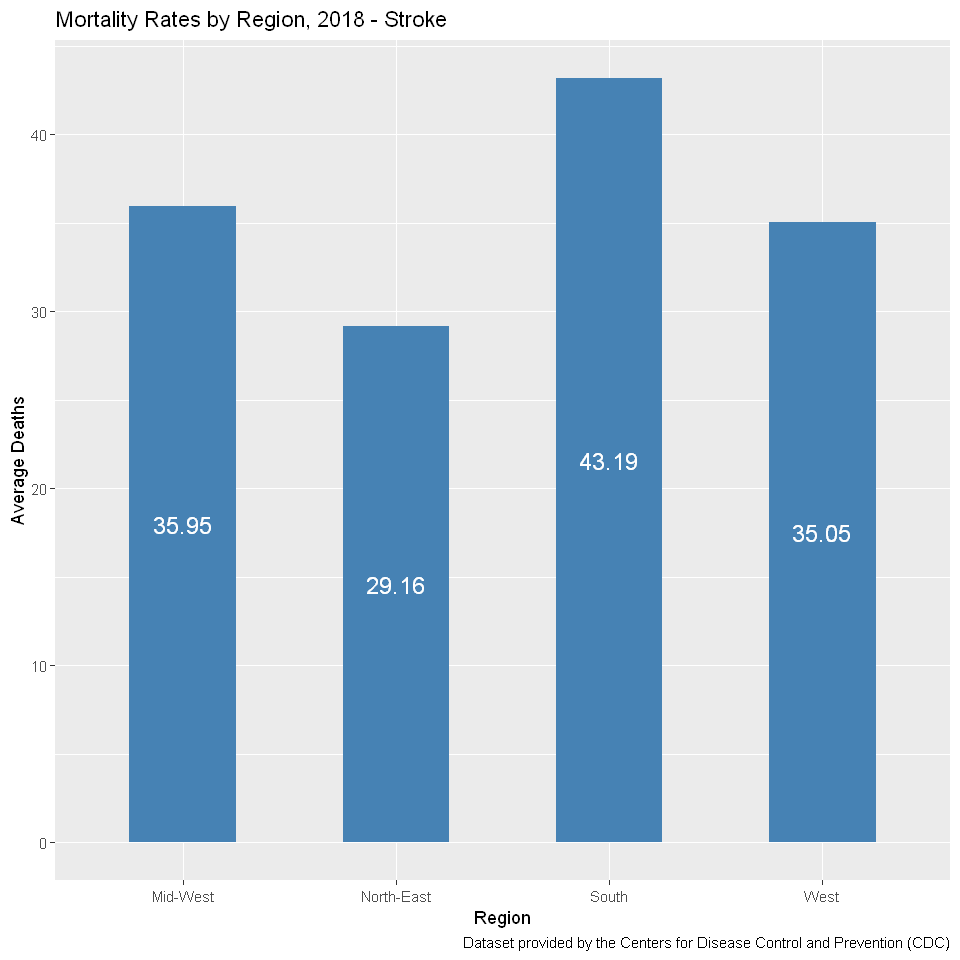

In [46]:
library(repr)
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data=rdf, aes_string(x="Region", y="stroke_AVG")) + geom_bar(stat="identity", fill="steelblue", width=0.5) + labs(title="Mortality Rates by Region, 2018 - Stroke", caption="Dataset provided by the Centers for Disease Control and Prevention (CDC)",y="Average Deaths") + geom_text(aes(label=round(stroke_AVG, digits=2)), position = position_stack(vjust=0.5), color="white", size=5)

In [47]:
    trends <- read.df("C:/Users/jack_/Desktop/Big Data Project/output/search_trends_Stroke_2018.csv", "csv", inferSchema = "true", header = "true", )
createOrReplaceTempView(trends, "trends")
search_trends <- collect(trends)
s <- sql("select stroke_avg, '2018' as Year from trends where Region = 'South'")
w <- sql("select stroke_avg, '2018' as Year from trends where Region = 'West'")
ne <- sql("select stroke_avg, '2018' as Year from trends where Region = 'North-East'")
mw <- sql("select stroke_avg, '2018' as Year from trends where Region = 'Mid-West'")
createOrReplaceTempView(s, "searchs18")
createOrReplaceTempView(w, "searchw18")
createOrReplaceTempView(ne, "searchne18")
createOrReplaceTempView(mw, "searchmw18")

In [51]:
south_searches <- sql("select * from searchs14 union select * from searchs15 union select * from searchs16 union select * from searchs17 union select * from searchs18")
west_searches <- sql("select * from seearchw14 union select * from seearchw15 union select * from seearchw16 union select * from seearchw17 union select * from seearchw18")
northeast_searches <- sql("select * from searchne14 union select * from searchne15 union select * from searchne16 union select * from searchne17 union select * from searchne18")
midwest_searches <- sql("select * from searchmw14 union select * from searchmw15 union select * from searchmw16 union select * from searchmw17 union select * from searchmw18")
createOrReplaceTempView(south_searches, "south_searches")
createOrReplaceTempView(west_searches, "west_searches")
createOrReplaceTempView(northeast_searches, "northeast_searches")
createOrReplaceTempView(midwest_searches, "midwest_searches")

In [52]:
south_totals <- sql("select 'Searches' as Category, stroke_avg, Year from south_searches union select 'Death Rate' as Category, stroke_AVG, Year from south")
west_totals <- sql("select 'Searches' as Category, stroke_avg, Year from west_searches union select 'Death Rate' as Category, stroke_AVG, Year from west")
northeast_totals <- sql("select 'Searches' as Category, stroke_avg, Year from northeast_searches union select 'Death Rate' as Category, stroke_AVG, Year from northeast")
midwest_totals <- sql("select 'Searches' as Category, stroke_avg, Year from midwest_searches union select 'Death Rate' as Category, stroke_AVG, Year from midwest")
south_rdf <- collect(south_totals)
west_rdf <- collect(west_totals)
northeast_rdf <- collect(northeast_totals)
midwest_rdf <- collect(midwest_totals)

In [36]:
head(south_rdf)

,Category,heart_health_avg,Year
,<chr>,<dbl>,<chr>
1,Searches,67.5900,2015
2,Death Rate,191.6500,2015
3,Searches,61.7100,2018
4,Death Rate,190.5062,2014
5,Searches,68.6500,2016
6,Searches,52.5900,2014


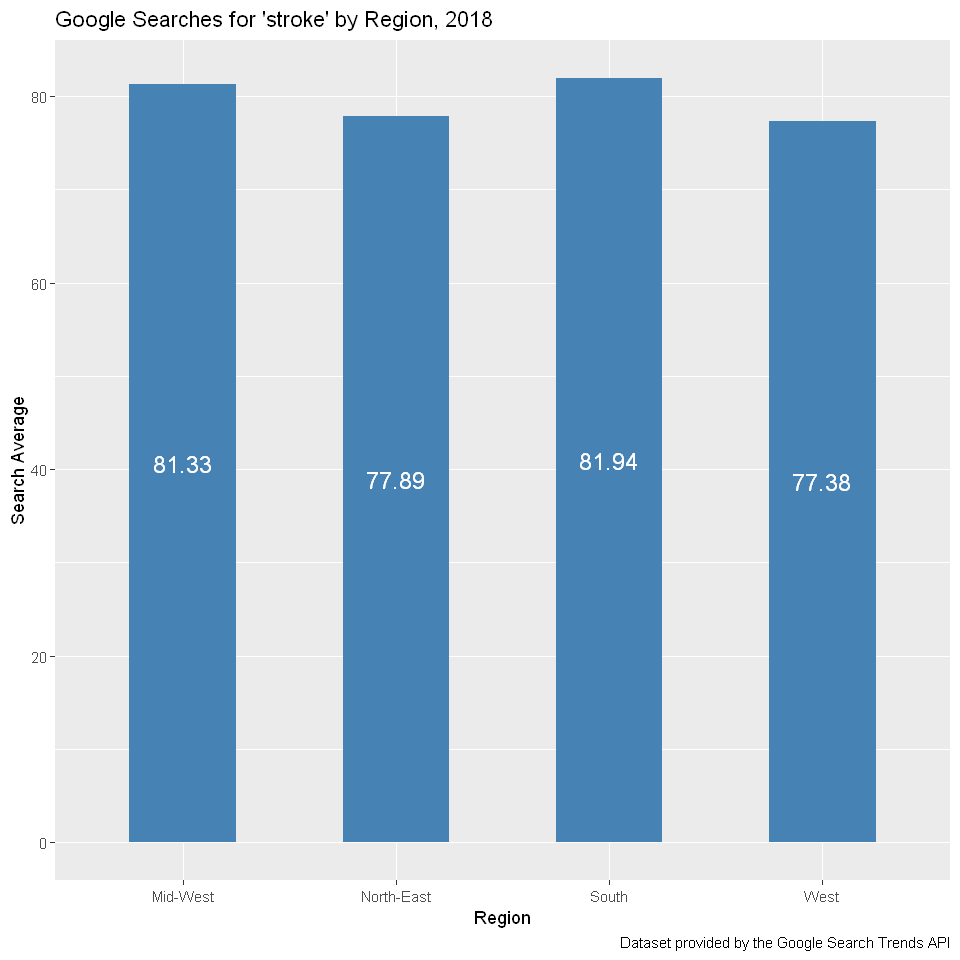

In [53]:
library(repr)
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data=search_trends, aes_string(x="Region", y="stroke_avg")) + geom_bar(stat="identity", fill="steelblue", width=0.5) + labs(title="Google Searches for 'stroke' by Region, 2018", caption="Dataset provided by the Google Search Trends API", y="Search Average") + geom_text(aes(label=stroke_avg), position = position_stack(vjust=0.5), color="white", size=5)

In [54]:
added1 <- sql("select c.Region, 'S_Search' as Label, cast(t.stroke_avg as decimal(5,2)) as stroke_avg, t.stroke_avg + c.stroke_AVG as stroke_sum from stroke_avg_by_reg c, trends t where c.Region = t.Region")
added2 <- sql("select t.Region, 'S_Death' as Label, cast(c.stroke_AVG as decimal(5,2)) as stroke_AVG, t.stroke_avg + c.stroke_AVG as stroke_sum from stroke_avg_by_reg c, trends t where c.Region = t.Region")
createOrReplaceTempView(added1, 'added1')
createOrReplaceTempView(added2, 'added2')
joined <- sql("select Region, Label, cast(stroke_avg as decimal(5,2)) as stroke_avg, cast(stroke_sum as decimal(5,2)) as stroke_sum from added1 union select Region, Label, cast(stroke_AVG as decimal(5,2)) as stroke_avg, cast(stroke_sum as decimal(5,2)) as stroke_sum from added2")
createOrReplaceTempView(joined, 'joined')
final <- collect(joined)
collect(joined)

,Region,Label,stroke_avg,stroke_sum
,<chr>,<chr>,<dbl>,<dbl>
1,Mid-West,S_Search,81.33,117.28
2,South,S_Death,43.19,125.13
3,West,S_Search,77.38,112.43
4,West,S_Death,35.05,112.43
5,North-East,S_Death,29.16,107.05
6,South,S_Search,81.94,125.13
7,North-East,S_Search,77.89,107.05
8,Mid-West,S_Death,35.95,117.28


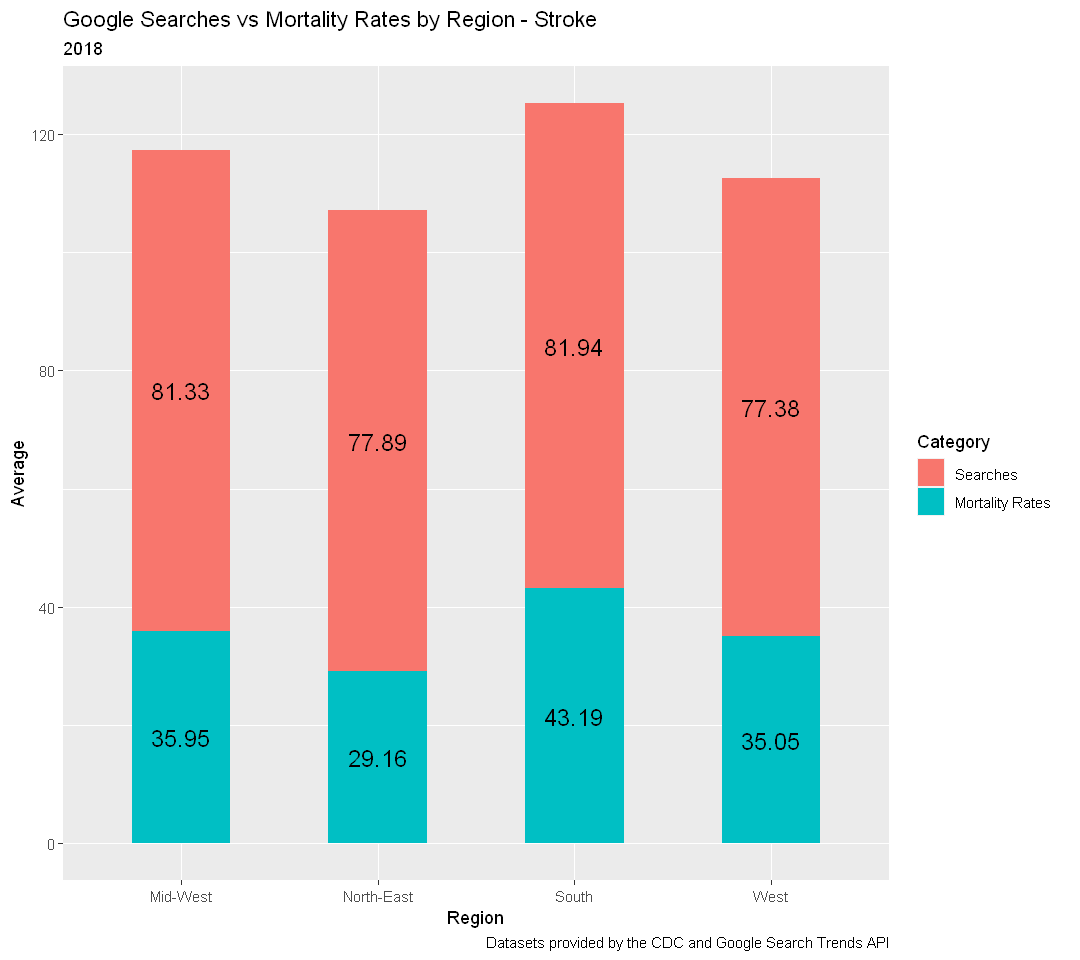

In [55]:
library(repr)
library(forcats)
options(repr.plot.width=9, repr.plot.height=8)
final$Label <- fct_rev(final$Label)
ggplot(data=final, aes_string(x="Region", y="stroke_avg", fill='Label')) + geom_bar(stat="identity", width=0.5) + geom_text(aes(label=stroke_avg), position = position_stack(vjust=0.5), color="black", size=5) + labs(title="Google Searches vs Mortality Rates by Region - Stroke", subtitle="2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average") + scale_fill_discrete(name = "Category", labels = c("Searches", "Mortality Rates"))

Warning message:
"Ignoring unknown aesthetics: digits"


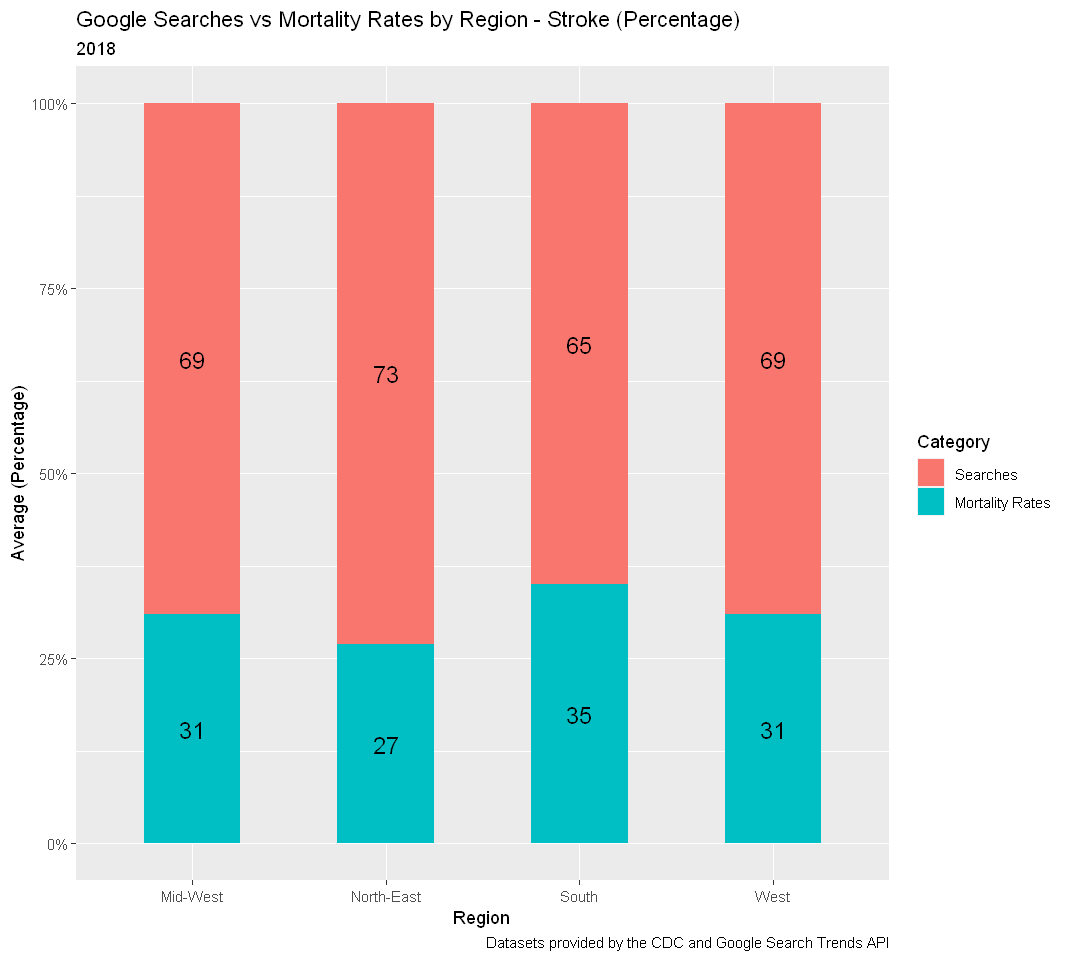

In [57]:
library(scales)
library(forcats)
options(repr.plot.width=9, repr.plot.height=8)
final$Label <- fct_rev(final$Label)
ggplot(data=final, aes(x=Region, y=round((stroke_avg/stroke_sum), digits=2), fill=Label)) + geom_bar(stat="identity", width=0.5) + geom_text(aes(label=round((stroke_avg/stroke_sum)*100), digits=2), position = position_stack(vjust=0.5), color="black", size=5) + labs(title="Google Searches vs Mortality Rates by Region - Stroke (Percentage)", subtitle="2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average (Percentage)") + scale_y_continuous(labels = percent_format(), limits=c(0,1)) + scale_fill_discrete(name = "Category", labels = c("Searches", "Mortality Rates"))

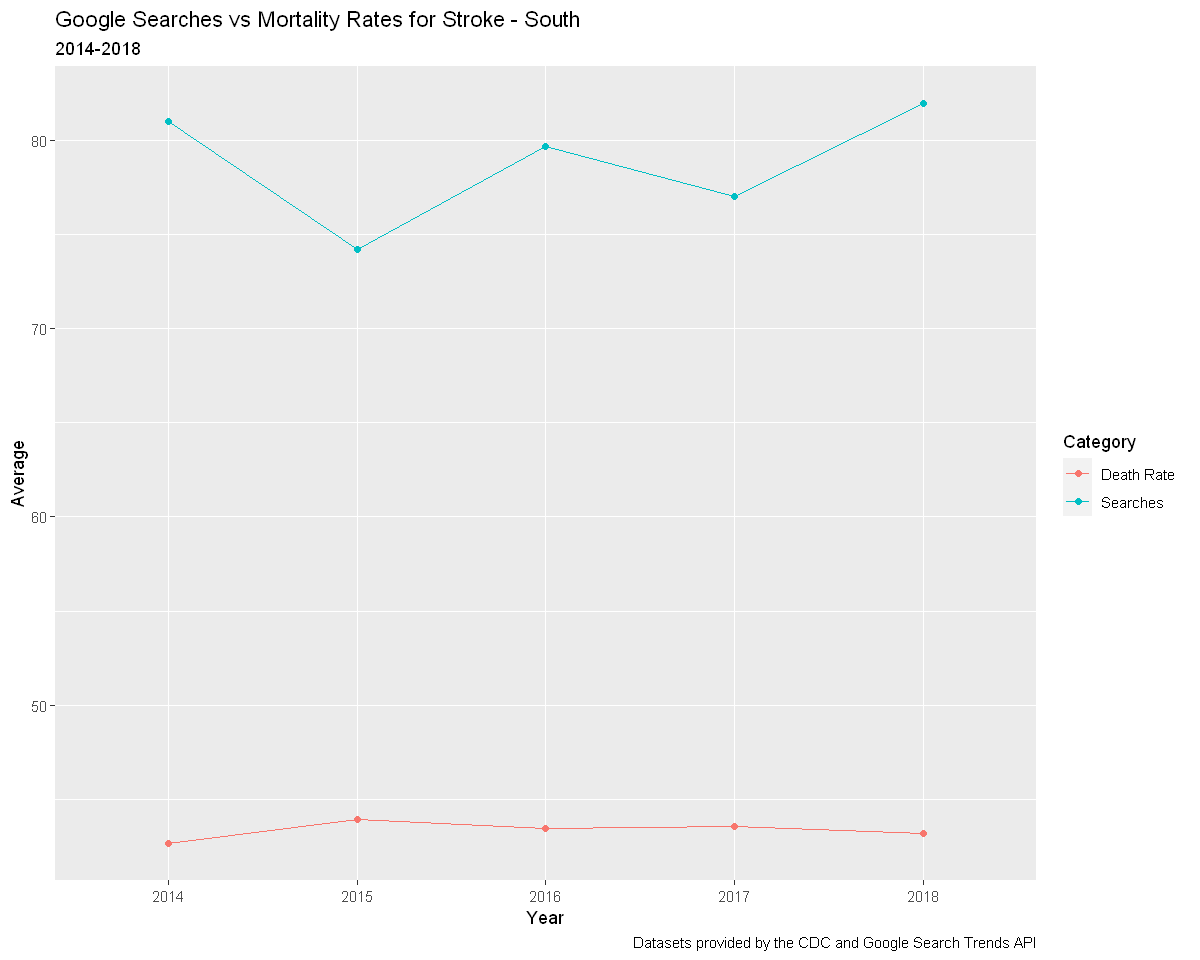

In [58]:
library(repr)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=south_rdf, aes(x=Year, y=stroke_avg, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
labs(title="Google Searches vs Mortality Rates for Stroke - South", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")

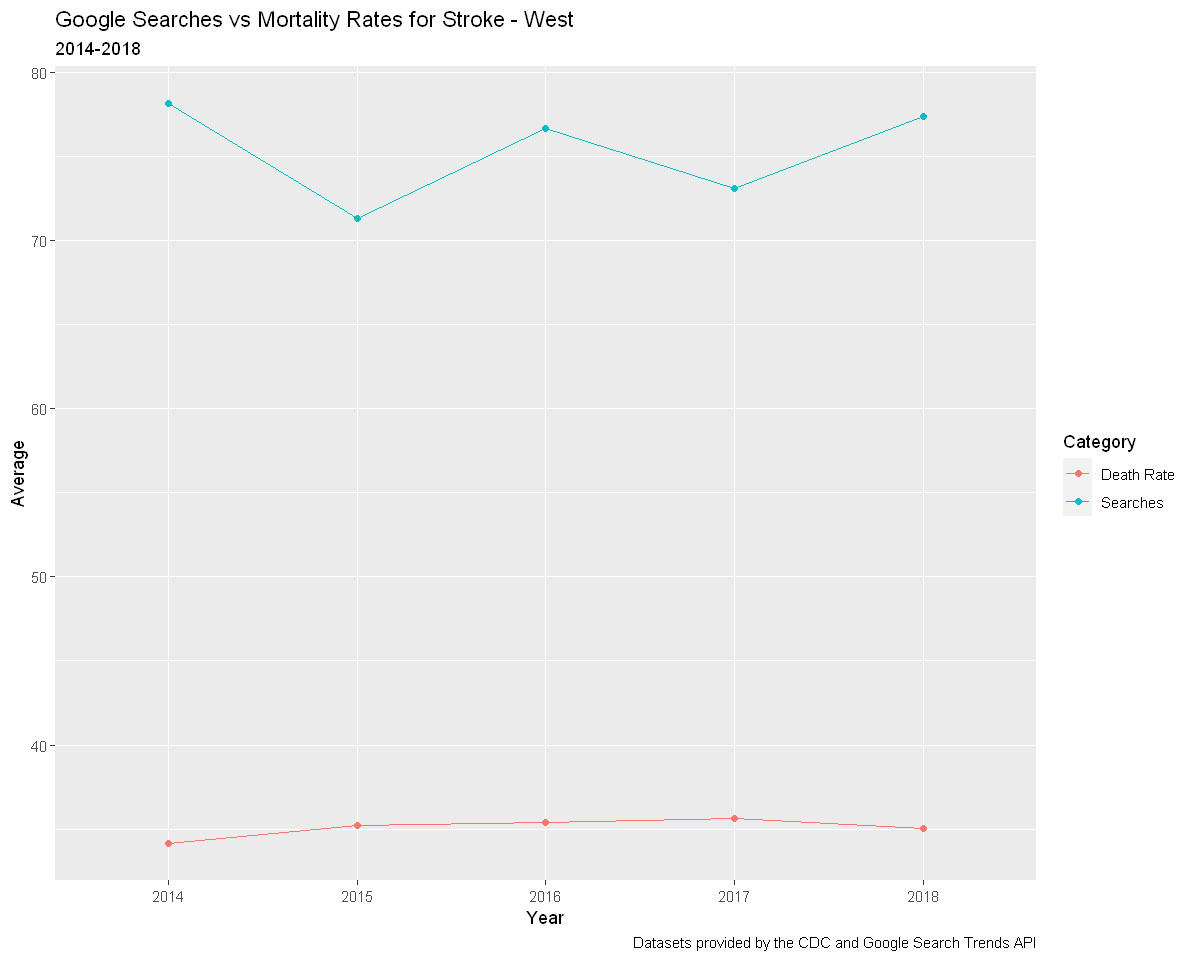

In [59]:
library(repr)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=west_rdf, aes(x=Year, y=stroke_avg, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
labs(title="Google Searches vs Mortality Rates for Stroke - West", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")

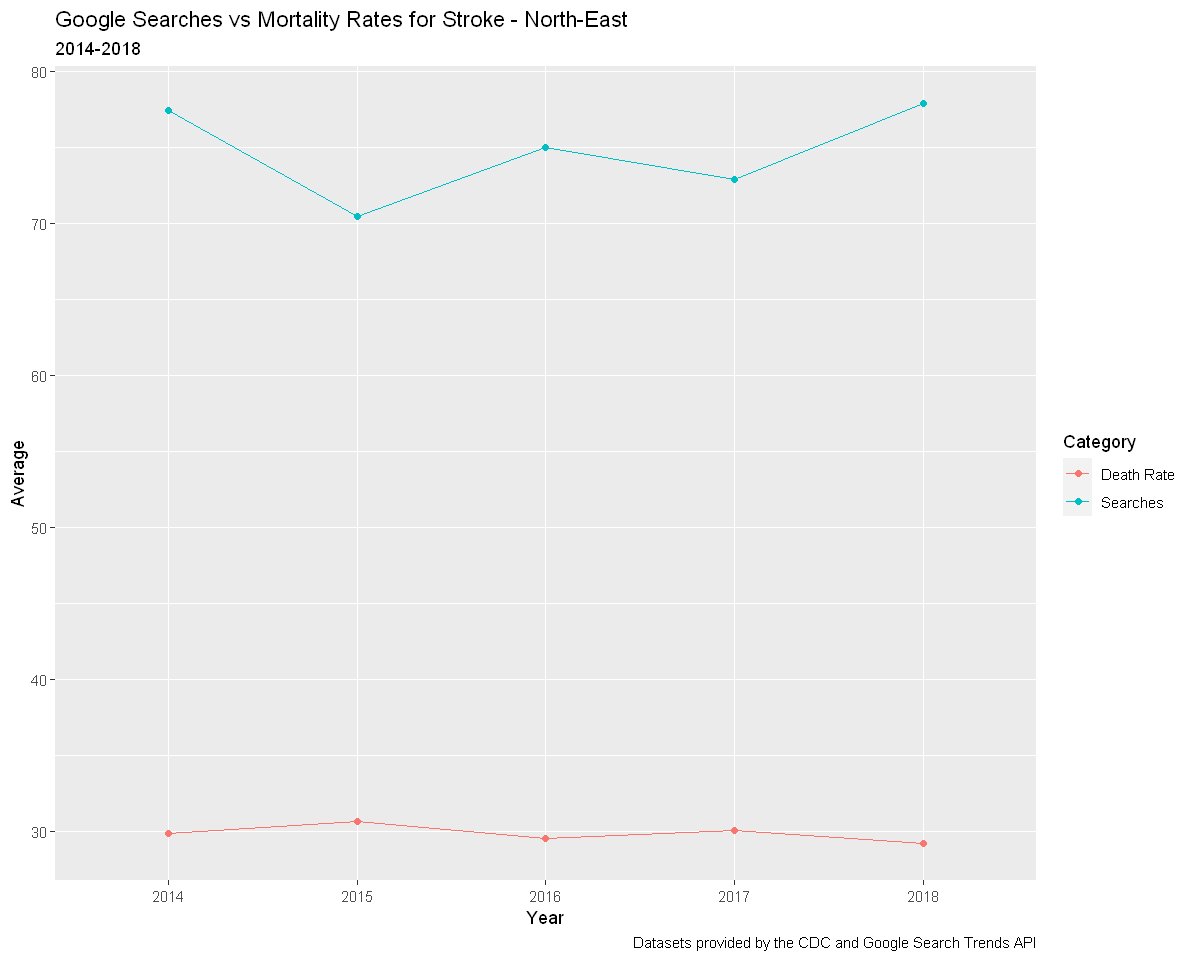

In [61]:
library(repr)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=northeast_rdf, aes(x=Year, y=stroke_avg, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
labs(title="Google Searches vs Mortality Rates for Stroke - North-East", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")

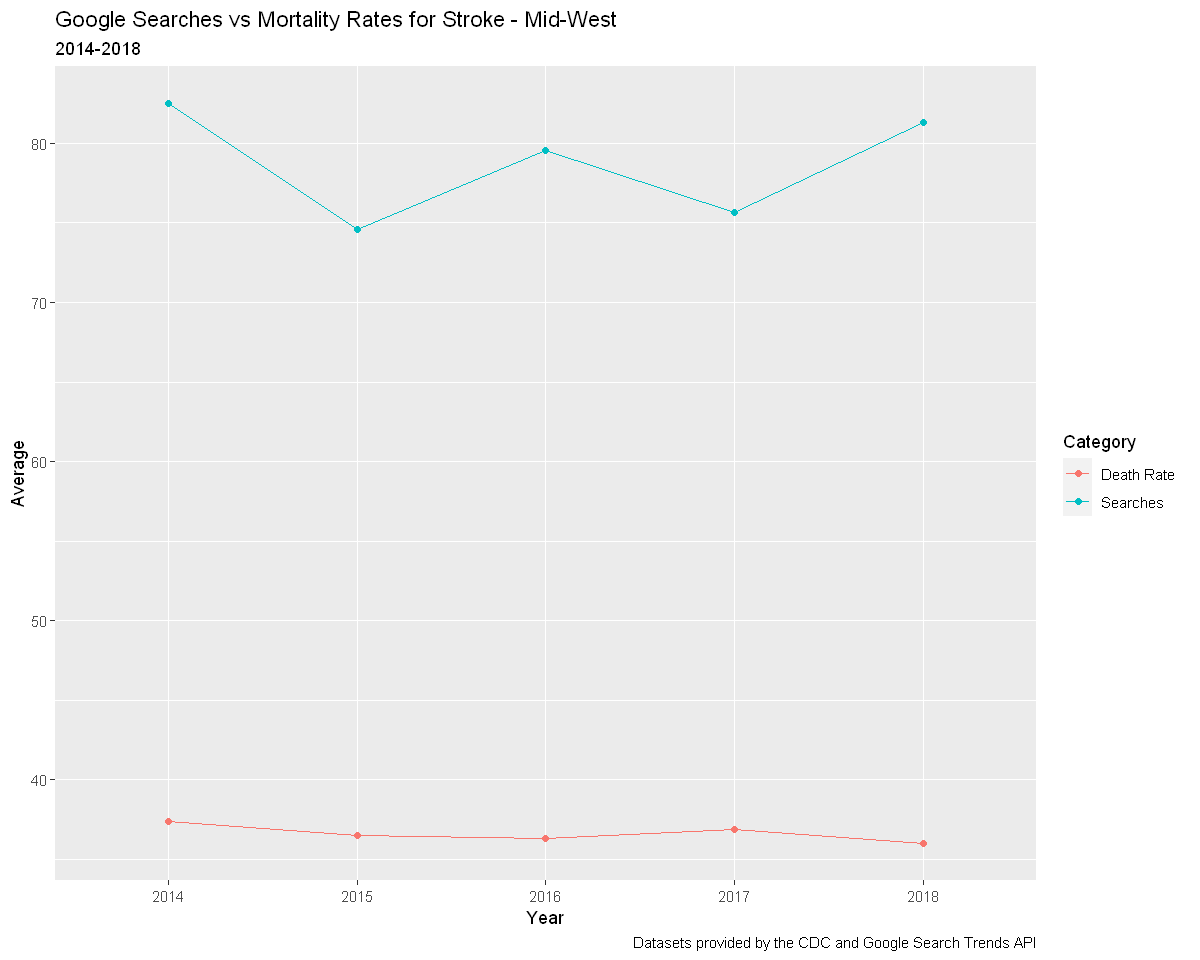

In [62]:
library(repr)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=midwest_rdf, aes(x=Year, y=stroke_avg, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
labs(title="Google Searches vs Mortality Rates for Stroke - Mid-West", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")